In [7]:
""" Import of modules """
import numpy.random as np
import numpy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from tqdm import tqdm_notebook as tqdm
sns.set()
sns.set_palette(sns.color_palette("viridis", 20))
sns.set_context("paper")
sns.set_style("ticks")

In [148]:
""" Initialization """
Npop = 10000 #Population size
parr = numpy.exp(numpy.arange(-24, -14)) #Mutation rate
narr = numpy.exp(numpy.arange(14, 25)) #Cell number

pdist = np.uniform(numpy.exp(-24), numpy.exp(-14), size=Npop)
ndist = np.uniform(numpy.exp(14), numpy.exp(25), size=Npop)

ndiv = 365 #Number of cell divisions per year
age = 100 #Lifespan
time = ndiv*age #Duration of the simulation

threshold = np.randint(2, 20, Npop) #Mutation threshold for cancer
n = narr[5] #Carrying capacity
# p = parr[5] #Mutation rate

# wts=numpy.array([0.013818048555027355, 0.0553159434123515, 0.07253241028642805, 0.07303103455912367, 0.07216711636515384, 0.06647847243710951, 0.06452984736662379, 0.07104508339877749, 0.08076197744193335, 0.08185169462960405, 0.07211714069611326, 0.06271758577923968, 0.048454493422914295, 0.038794489715138394, 0.034263609991378986, 0.03177168658747205, 0.026997999757072733, 0.017842803104216928, 0.01550856249432107]) #Weights from the US 2000 standard population
# n_class = len(wts)

# persistence = numpy.zeros(Npop*(threshold-1)).reshape(Npop, (threshold-1))
cancer_time = numpy.zeros(Npop)
# crc, cmc, crr = numpy.zeros(len(parr)*age).reshape(len(parr),age), numpy.zeros(len(parr)*age).reshape(len(parr),age), numpy.zeros(len(parr)*age).reshape(len(parr),age)
# pmean, pstd = numpy.zeros(len(parr)*(threshold-1)).reshape(len(parr), threshold-1), numpy.zeros(len(parr)*(threshold-1)).reshape(len(parr), threshold-1)

nzeros = numpy.zeros
RAND = np.random_sample
# dataframe = pd.DataFrame

flag = 0
# for p in tqdm(parr, desc='Mutation rate', leave=False):
cancer_count = nzeros(age) #Age-wise incidence of cancer
num_surv = nzeros(age) #Number of survivors in each age/generation
cancer_fract = nzeros(age) #Normalized incidence of cancer
cumul_count = nzeros(age) #Cumulative count of cancer
crude_rate = nzeros(age) #Calculated age-wise incidence per 100000

for j, p, k in zip(tqdm(range(Npop), desc='Npop', leave=False), pdist, threshold):
    t=0 #Index to track time
#     mut_thr = threshold[j]
    n_mut = nzeros(time, dtype=int) #Number of mutations
    m = nzeros((k+1)*time).reshape((k+1), time)
    g = numpy.linspace(0.007, 0.007*(k+1), num=k+1) #Growth rate progression
    d = g[0]/5 #Constant death rate
    m[0, 0] = 1

    for t in range(1, time):

        n_mut[t] = n_mut[t-1]
        m[:, t] = m[:, t-1]
        p_mut = 1-(1-p)**m[n_mut[t], t]

        if p_mut > RAND(): #New mutant population
            n_mut[t] += 1
            m[n_mut[t], t] = 1.0
            p_mut = 1-((1-p)**m[n_mut[t], t])
            m[n_mut[t]-1, t] -= 1.0

        elif n_mut[t] < k: #Growth of existing mutant or normal population, as the case may be
            m[:, t] += ((m[:, t]*g*(n-m[:, t].sum())/n) - m[:, t]*d)
            p_mut = 1-(1-p)**m[n_mut[t], t]

        if n_mut[t] == k:
            cancer_count[int(t/ndiv)] += 1
#             persistence[j] = numpy.array([len(n_mut[n_mut==a]) for a in range(1,mut_thr)])
            cancer_time[j] = t
            break

""" Calculations """
cumul_count = cancer_count.cumsum()

num_surv = numpy.array([Npop]*age, dtype=float)
num_surv[1:] -= cumul_count[:-1]

index = num_surv>0
cancer_fract[index] = cancer_count[index]/(cancer_count[index]+num_surv[index])
crude_rate = cancer_fract*100000
    
#     crc[flag] = cancer_count[:]
#     cmc[flag] = cumul_count[:]
#     crr[flag] = crude_rate[:]
#     pmean[flag] = persistence.mean(axis=0)[:]
#     pstd[flag] = persistence.std(axis=0)[:]
#     flag += 1

In [153]:
cancer_time[cancer_time!=0].shape

(4382,)

In [154]:
psen_data = pd.DataFrame(numpy.array([numpy.log10(pdist[cancer_time!=0]), threshold[cancer_time!=0], cancer_time[cancer_time!=0]/ndiv]).T, columns=['log(p)', 'Threshold', 'Time to cancer'])
# nsen_data = pd.DataFrame(numpy.array([numpy.log10(narr[cancer_time!=0]), threshold[cancer_time!=0], cancer_time[cancer_time!=0]/ndiv]).T, columns=['log(n)', 'Threshold', 'Time to cancer'])

In [166]:
# nsen_data.to_csv('/home/iiser/PhD/github-cancer-incidence-models/all-data/sensitivity-data/linear-v1-cancer-time-k&n-rand.xls')
psen_data.to_csv('/home/iiser/PhD/github-cancer-incidence-models/all-data/sensitivity-data/linear-v1-cancer-time-k&p-rand.xls')

/home/iiser/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/iiser/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


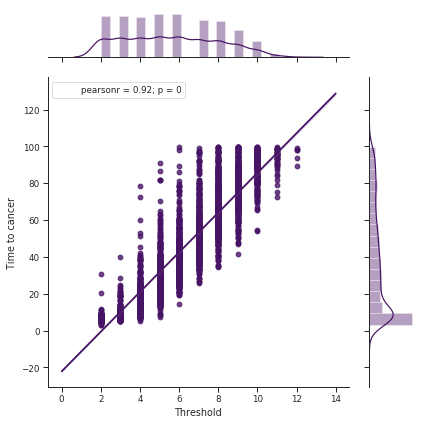

In [157]:
sns.jointplot(x='Threshold', y='Time to cancer', data=psen_data, kind='reg', stat_func=stats.pearsonr)
plt.tight_layout()
plt.savefig('/home/iiser/PhD/github-cancer-incidence-models/all-figures/sensitivity-figures/linear-v1-k-vs-cancer-time-prand-12Nov.svg')

/home/iiser/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/iiser/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


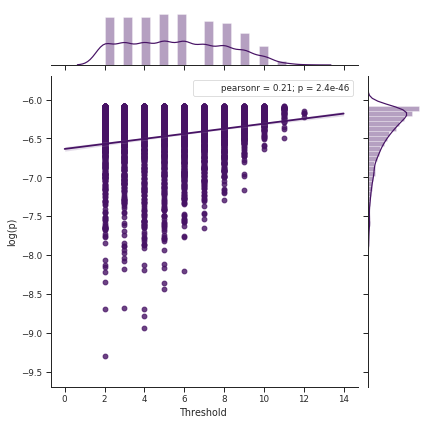

In [158]:
sns.jointplot(x='Threshold', y='log(p)', data=psen_data, kind='reg', stat_func=stats.pearsonr)
plt.savefig('/home/iiser/PhD/github-cancer-incidence-models/all-figures/sensitivity-figures/linear-v1-k-vs-p-12Nov.svg')

/home/iiser/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/iiser/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


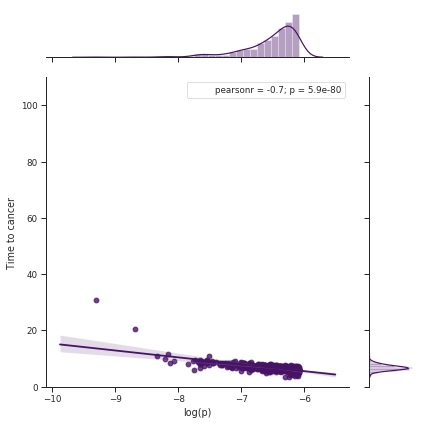

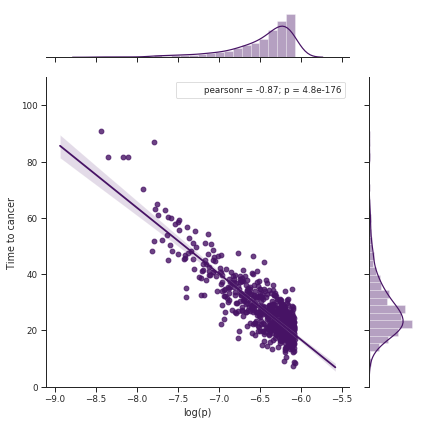

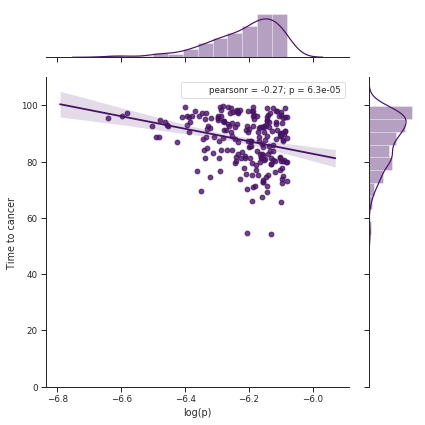

In [167]:
jp1 = sns.jointplot(x='log(p)', y='Time to cancer', data=psen_data.where(psen_data['Threshold']==2), kind='reg', ylim=(0, 110), stat_func=stats.pearsonr)
plt.tight_layout()
plt.savefig('/home/iiser/PhD/github-cancer-incidence-models/all-figures/sensitivity-figures/linear-v1-p-vs-cancer-time-k-2-12Nov.svg')
jp2 = sns.jointplot(x='log(p)', y='Time to cancer', data=psen_data.where(psen_data['Threshold']==5), kind='reg', ylim=(0, 110), stat_func=stats.pearsonr)
plt.tight_layout()
plt.savefig('/home/iiser/PhD/github-cancer-incidence-models/all-figures/sensitivity-figures/linear-v1-p-vs-cancer-time-k-5-12Nov.svg')
jp3 = sns.jointplot(x='log(p)', y='Time to cancer', data=psen_data.where(psen_data['Threshold']==10), kind='reg', ylim=(0, 110), stat_func=stats.pearsonr)
plt.tight_layout()
plt.savefig('/home/iiser/PhD/github-cancer-incidence-models/all-figures/sensitivity-figures/linear-v1-p-vs-cancer-time-k-10-12Nov.svg')